# Using AutoSDF

Use this file to generate 3D models using AutoSDF
Make sure the AutoSDF repository is located in in the same parent directory as `completiontools-evaluation`

## Importing and set-up

In [6]:
# Import packages and Setup everything
import os
import json
import torch
import pytorch3d.io
import sys
import comptools
from pathlib import Path
# some utility function for visualization from AutoSDF
sys.path.insert(0, '../')
import AutoSDF.utils as utils
from AutoSDF.utils.util_3d import init_mesh_renderer, sdf_to_mesh
from AutoSDF.utils.demo_util import get_shape_comp_opt
from AutoSDF.utils.demo_util import get_shape_comp_model
from AutoSDF.utils.qual_util import save_mesh_as_gif, save_meshes_to_file, get_partial_shape_by_voxels, get_partial_shape_by_range, get_shape_comp_input_mesh
from IPython.display import Image as ipy_image
from IPython.display import display

# enable hot reloading
%reload_ext autoreload
%autoreload 2

# set up the results directory
input_data_folder_path = r"/home/student/Documents/Data/meshes_data/synthetisch_meshes_v2/"
voxel_data_folder_path = r"/home/student/Documents/Data/Voxeldata/"
res_dir = r"/home/student/Documents/Data/AutoSDF_results"
if not os.path.exists(res_dir): os.makedirs(res_dir)

# Define the options, in this case which GPU we want to use
gpu_id = 0
opt = get_shape_comp_opt(gpu_id=gpu_id)
print(opt.device)

# Setup the object completion model
model = get_shape_comp_model(opt, root = "../AutoSDF")    
model.eval()

# Setup the renderer to display gifs
dist, elev, azim = 1.7, 20, 110
mesh_renderer = init_mesh_renderer(image_size=256, dist=dist, elev=elev, azim=azim, device=opt.device)

cuda:0
[*] Enc has Attn at i_level, i_block: 3, 0
Working with z of shape (1, 256, 8, 8, 8) = 131072 dimensions.
[*] Dec has Attn at i_level, i_block: 3, 0
[*] VQVAE: weight successfully load from: ../AutoSDF/saved_ckpt/pvqvae-snet-all-LR1e-4-T0.2-rerun-epoch140.pth
[*] Model has been created: Rand-Transformer-Model
[*] "rand_tf" initialized.
[*] weight successfully load from: ../AutoSDF/saved_ckpt/rand_tf-snet_code-all-LR1e-4-clean-epoch200.pth


In [7]:
input_list = []
for subdir, dirs, files in os.walk(input_data_folder_path):
    for file in files:
        #print os.path.join(subdir, file)
        filepath = subdir + os.sep + file

        if filepath.endswith(".pt"):
            #print (filepath)
            input_list.append(filepath)

voxel_list = []
for subdir, dirs, files in os.walk(voxel_data_folder_path):
    for file in files:
        #print os.path.join(subdir, file)
        filepath = subdir + os.sep + file

        if filepath.endswith(".txt"):
            #print (filepath)
            voxel_list.append(filepath)

print(input_list)
print(voxel_list)

['/home/student/Documents/Data/meshes_data/synthetisch_meshes_v2/buis_recht/recht_bocht_180/sdf.pt', '/home/student/Documents/Data/meshes_data/synthetisch_meshes_v2/buis_recht/recht_T_90/sdf.pt', '/home/student/Documents/Data/meshes_data/synthetisch_meshes_v2/buis_recht/recht_bocht_30/sdf.pt', '/home/student/Documents/Data/meshes_data/synthetisch_meshes_v2/buis_recht/recht_bocht_60+60/sdf.pt', '/home/student/Documents/Data/meshes_data/synthetisch_meshes_v2/buis_recht/recht_verzamel/sdf.pt', '/home/student/Documents/Data/meshes_data/synthetisch_meshes_v2/buis_recht/recht_versmal_lang/sdf.pt', '/home/student/Documents/Data/meshes_data/synthetisch_meshes_v2/buis_recht/recht_T_45/sdf.pt', '/home/student/Documents/Data/meshes_data/synthetisch_meshes_v2/buis_recht/recht_Y_60/sdf.pt', '/home/student/Documents/Data/meshes_data/synthetisch_meshes_v2/buis_recht/recht_versmal/sdf.pt', '/home/student/Documents/Data/meshes_data/synthetisch_meshes_v2/buis_recht/recht_S_60/sdf.pt', '/home/student/Doc

## One-click-generation

In [8]:
for i in range(1):#len(input_list)):
    sdfPath = input_list[i]
    # Get the shape completion input
    print("Getting the shape completion input")
    sdf = torch.load(sdfPath,map_location=torch.device(opt.device))
    fileFolder = Path(input_list[i]).parent.parent.name
    fileName = Path(input_list[i]).parent.name
    
    for j in range(1):#len(voxel_list)):
        jsonPath = voxel_list[j]
        jsonName = Path(voxel_list[j]).stem
        occ_grid = comptools.read_voxel_file(jsonPath)
        shape_comp_input = get_partial_shape_by_voxels(sdf, occ_grid, device=opt.device)

        # Define the incomplete mesh
        print("perform shape completion")
        input_mesh = get_shape_comp_input_mesh(shape_comp_input['sdf'], shape_comp_input['sdf_missing'])
        input_mesh, comp_sdf = model.shape_comp(shape_comp_input, bs=3, topk=30)
        gen_mesh = sdf_to_mesh(comp_sdf)          # completed shape

        # save as gif
        #gen_gif_name = f'{res_dir}/shape-comp-struct-input-gen.gif'
        #save_mesh_as_gif(mesh_renderer, gen_mesh, nrow=3, out_name=gen_gif_name,device = opt.device)
        #display(ipy_image(gen_gif_name))

        # Save to files
        print("Saving Meshes: " + str(i) + ", " + str(j))
        saveFolder =  os.path.join(res_dir,fileFolder, fileName, jsonName)
        if not os.path.exists(saveFolder): os.makedirs(saveFolder)
        save_meshes_to_file(gen_mesh,saveFolder)
print("Done")

Getting the shape completion input
Loading the Json file
perform shape completion


[*] autoregressively inferencing...: 100%|██████████| 256/256 [00:09<00:00, 26.14it/s]


Saving Meshes: 0, 0
Done


# Step-by-step

## Import the SDF

In [2]:
#sdfPath = "/srvgentjkd98p2/L/Recordings/2015-01 ShapeNetCore/03001627/1a8bbf2994788e2743e99e0cae970928/models/model_normalized_sdf.pt"
sdfPath = r"/home/student/Documents/Data/Input_puntenwolken/Revit_kopie thesis - 3D View - 3D_Brouwerij_buis_rechthoek/sdf.pt"
sdf = torch.load(sdfPath,map_location=torch.device(opt.device))

In [3]:
gen_sdf_as_mesh = sdf_to_mesh(sdf) 

# save as gif
gif_name = f'{res_dir}/shape-example.gif'
save_mesh_as_gif(mesh_renderer, gen_sdf_as_mesh, nrow=1, out_name=gif_name)
ipy_image(gif_name)

## Get The Partial Range

### By Voxels

In [5]:
# Load the JSON file
with open('./demo_data/voxelgrid_half.txt', 'r') as file:
    data = json.load(file)
voxels = data['voxels']
occ_grid = []
for voxel in voxels:
    id = voxel['gridIndex']
    occ_grid.append([id['x'], id['y'], id['z']])

shape_comp_input = get_partial_shape_by_voxels(sdf, occ_grid, device=opt.device)

### By Range

In [4]:
completionPercent = "50"
# range: -1 ~ 1.
# x: left-to-right; y: bottom-to-top; z: front-to-back
min_x, max_x = -1., 1.
min_y, max_y = -1, 1.
min_z, max_z = 0.3, 1.
input_range = {'x1': min_x, 'x2': max_x, 'y1': min_y, 'y2': max_y, 'z1': min_z, 'z2': max_z}

shape_comp_input = get_partial_shape_by_range(sdf, input_range)

### Get Partial Mesh

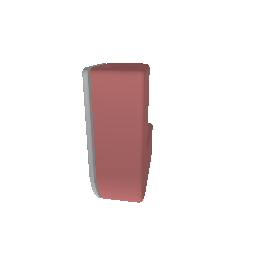

In [5]:
input_mesh = get_shape_comp_input_mesh(shape_comp_input['sdf'], shape_comp_input['sdf_missing'])

# save as gif
gif_name = f'{res_dir}/shape-comp-struct-input-inp.gif'
save_mesh_as_gif(mesh_renderer, input_mesh, nrow=1, out_name=gif_name, device = opt.device)
display(ipy_image(gif_name))

## Shape Completion

In [6]:
""" perform shape completion """
input_mesh, comp_sdf = model.shape_comp(shape_comp_input, bs=3, topk=30)
gen_mesh = sdf_to_mesh(comp_sdf)          # completed shape

# save as gif
gen_gif_name = f'{res_dir}/shape-comp-struct-input-gen.gif'
save_mesh_as_gif(mesh_renderer, gen_mesh, nrow=3, out_name=gen_gif_name,device = opt.device)
display(ipy_image(gen_gif_name))

[*] autoregressively inferencing...: 100%|██████████| 320/320 [00:11<00:00, 28.94it/s]


In [7]:
save_meshes_to_file(gen_mesh, res_dir)